In [1]:
import os
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from statistics import mean, stdev
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

## Ukuran plot besar
# sns.reset_defaults()
# Ukuran plot kecil
sns.reset_orig()

sns.set_style('whitegrid', {'grid.linestyle': '--'})

In [2]:
np.random.seed(500)

## Prepare Input

Corpus memuat teks yang sudah dibersihkan (di tahap prapengolahan). Label Inset memuat label teks dengan leksikon InSet. LabelSenti memuat label teks dengan leksikon sentiStrength

In [21]:
# Merubah file menjadi txt
import csv

def csv_to_txt(csv_file, txt_file):
    with open(csv_file, 'r') as file:
        csv_data = csv.reader(file)
        with open(txt_file, 'w') as txtfile:
            for row in csv_data:
                txtfile.write(','.join(row) + '\n')

# Specify the input CSV file and output TXT file names
csv_file = 'data_preproses clean.csv'
txt_file = 'data_preproses clean.txt'

# Call the function to convert CSV to TXT
csv_to_txt(csv_file, txt_file)

In [22]:
# Pastikan untuk mengganti path dengan absolute path direktorimu jika baris berikut dijalankan ulang, atau restart kernel.
base = 'data_preproses clean.txt'
lb_inset = 'data_preproses clean-lb-inset.txt'
lb_senti = 'data_preproses clean-lb-senti.txt'

Corpus = pd.read_csv(base, encoding='latin-1', header=None, sep='\t', names=['text'], dtype=str)
LabelInset = pd.read_csv(lb_inset, encoding='latin-1', header=None, names=['label'], dtype=str)
LabelSenti = pd.read_csv(lb_senti, encoding='latin-1', header=None, names=['label'], dtype=str)

In [23]:
# Jumlah positif dan negatif dari setiap jenis pelabelan
neg1, pos1 = (LabelInset['label'][LabelInset['label']=='neg']).count(), (LabelInset['label'][LabelInset['label']=='pos']).count()
neg2, pos2 = (LabelSenti['label'][LabelSenti['label']=='neg']).count(), (LabelSenti['label'][LabelSenti['label']=='pos']).count()
print('neg:', neg1, '(', '{0:.2f}'.format(neg1/(neg1+pos1)*100), '%)','\t', 'pos:', pos1, '(', '{0:.2f}'.format(pos1/(neg1+pos1)*100),'%)',' | inset')
print('neg:', neg2, '(', '{0:.2f}'.format(neg2/(neg2+pos2)*100), '%)','\t', 'pos:', pos2, '(', '{0:.2f}'.format(pos2/(neg2+pos2)*100),'%)',' | senti')

neg: 635 ( 63.76 %) 	 pos: 361 ( 36.24 %)  | inset
neg: 741 ( 74.40 %) 	 pos: 255 ( 25.60 %)  | senti


### Menggunakan pelabelan dari Lexion Based Indonesia / InSet

In [75]:
#Menggunakan pelabelan dari InSet
LL = LabelInset

In [25]:
print(Corpus[:3], '\n\n', LL[:3])

                                                text
0                                              tweet
1  direktur jenderal badan kesehatan dunia who me...
2  semua negara dunia menyerukan pentingnya imuni... 

   label
0   neg
1   neg
2   neg


### Tokenisasi

In [26]:
# Step - a : Menghapus baris kosong, jika ada.
Corpus['text'].dropna(inplace=True)
# # Step - b : Mengganti semua teks ke karakter kecil karena 'oke' dan 'OKE' diinterpretasikan berbeda
# Corpus['text'] = [entry.lower() for entry in Corpus['text']] # we've done this in '[1] text cleaning.ipynb'
# Step - c : Tokenisasi : Setiap kalimat di dalam korpus akan dipecah menjadi daftar kata/string
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]

for index,entry in enumerate(Corpus['text']):
    # Mendeklarasikan list kosong untuk menyimpan daftar kata yang sesuai dengan aturan yang dibuat
    Final_words = []
    for word in entry:
        # Kondisi di bawah adalah untuk mengecek/mempertimbangkan alfabet saja
        if word.isalpha():
            word_Final = word
            Final_words.append(word_Final)
    Corpus.loc[index,'text_final'] = str(Final_words)

In [27]:
print(Corpus[:3])

                                                text  \
0                                            [tweet]   
1  [direktur, jenderal, badan, kesehatan, dunia, ...   
2  [semua, negara, dunia, menyerukan, pentingnya,...   

                                          text_final  
0                                          ['tweet']  
1  ['direktur', 'jenderal', 'badan', 'kesehatan',...  
2  ['semua', 'negara', 'dunia', 'menyerukan', 'pe...  


### Split Data

In [28]:
# Membagi set data latih dan data uji dengan rasio 70:30
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],LL['label'],test_size=0.3, random_state=42)

In [29]:
print(Train_X.size, Train_X.size/(Test_X.size+Train_X.size),'%','\n',
      Test_X.size, Test_X.size/(Test_X.size+Train_X.size),'%')

697 0.6997991967871486 % 
 299 0.3002008032128514 %


In [30]:
# Encoding label menjadi nilai antara 0 and kelas_n-1
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

### Ekstraksi Fitur Teks

#### Bag of Words

In [32]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(Corpus['text_final'])

In [33]:
# Transform Train_X dan Test_X ke vektor BoW
Train_X_BoW = vectorizer.transform(Train_X)
Test_X_BoW = vectorizer.transform(Test_X)

#### Tf_IDF

In [35]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(Corpus['text_final'])

X = Tfidf_vect.fit_transform(Corpus['text_final'])

In [36]:
# Transform Train_X dan Test_X ke vektor TF-IDF
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

### Hyperparameter Optimization using GridSearch CV

Sebuah teknik yang digunakan untuk mencari kombinasi terbaik dari hyperparameter dalam sebuah model machine learning menggunakan metode GridSearchCV. Hyperparameter adalah parameter yang ditentukan di luar model machine learning itu sendiri dan tidak dipelajari oleh model selama proses training.
<br><br> GridSearch CV adalah metode untuk melakukan pencarian ke dalam ruang hyperparameter secara sistematis. Pada dasarnya, metode ini akan mencoba semua kombinasi yang mungkin dari hyperparameter yang ditentukan sebelumnya dan mengevaluasi performa model untuk setiap kombinasi tersebut menggunakan teknik validasi silang (cross-validation). Dengan menggunakan teknik ini, kita dapat mengidentifikasi kombinasi hyperparameter yang memberikan performa terbaik untuk model kita.
<br><br>Proses GridSearch CV bekerja dengan cara berikut:
1. Mendefinisikan model yang akan diuji serta daftar hyperparameter yang ingin dioptimasi.
2. Menentukan kombinasi yang mungkin dari hyperparameter yang ingin diuji.
3. Untuk setiap kombinasi hyperparameter, melakukan training dan evaluasi model menggunakan teknik validasi silang.
4. Mencatat performa model untuk setiap kombinasi hyperparameter.
5. Memilih kombinasi hyperparameter yang memberikan performa terbaik berdasarkan evaluasi yang dilakukan.
6. GridSearch CV memungkinkan kita untuk melakukan eksplorasi sistematis terhadap ruang hyperparameter dan mencari kombinasi yang menghasilkan performa terbaik untuk model kita. Dengan mencoba berbagai kombinasi hyperparameter, kita dapat meningkatkan performa model dan mengoptimalkan hasil prediksi.

In [38]:
# instantiate classifier with default hyperparameters with kernel=rbf, C=1.0 and gamma=auto/scale
svc=SVC() 

# declare parameters for hyperparameter tuning
parameters = [ {'C':[1, 100, 1000], 'kernel':['linear']},
               {'C':[1, 100, 1000], 'kernel':['rbf'], 'gamma':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
               {'C':[1, 100, 1000], 'kernel':['poly'], 'degree': [2,3,4] ,'gamma':[0.01,0.02,0.03,0.04,0.05]} 
              ]

grid_search = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


#Train data BoW
grid_search.fit(Train_X_BoW, Train_Y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [39]:
grid_search_Tfidf = GridSearchCV(estimator = svc,  
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)
#Train data TF-IDF
grid_search_Tfidf.fit(Train_X_Tfidf, Train_Y)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid=[{'C': [1, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 100, 1000],
                          'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                    0.9],
                          'kernel': ['rbf']},
                         {'C': [1, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']}],
             scoring='accuracy')

In [40]:
### BoW ###

In [41]:
# examine the best model
# best score achieved during the GridSearchCV
print('\n\n---BoW---\n')
print('GridSearch CV best score : {:.4f}\n'.format(grid_search.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :', (grid_search.best_params_))
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (grid_search.best_estimator_))



---BoW---

GridSearch CV best score : 0.7188

Parameters that give the best results : {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Estimator that was chosen by the search : SVC(C=100, gamma=0.1)


In [42]:
### TF-IDF ###

In [43]:
# examine the best model
# best score achieved during the GridSearchCV
print('\n\n---TF-IDF---\n')
print('GridSearch CV best score : {:.4f}\n'.format(grid_search_Tfidf.best_score_))
# print parameters that give the best results
print('Parameters that give the best results :', (grid_search_Tfidf.best_params_))
# print estimator that was chosen by the GridSearch
print('\nEstimator that was chosen by the search :', (grid_search_Tfidf.best_estimator_))



---TF-IDF---

GridSearch CV best score : 0.7446

Parameters that give the best results : {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}

Estimator that was chosen by the search : SVC(C=100, gamma=0.1)


In [44]:
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search.score(Test_X_BoW, Test_Y)))
# calculate GridSearch CV score on test set
print('GridSearch CV score on test set: {0:0.4f}'.format(grid_search_Tfidf.score(Test_X_Tfidf, Test_Y)))

GridSearch CV score on test set: 0.6923
GridSearch CV score on test set: 0.7157


### Definisikan Classifier

Mendefinisikan clisifier berdasarkan best score pada masing-masing kombinasi fitur ekstraksi dan leksikon

In [54]:
# Menggunakan SVM dengan kernel hasil Grid Search CV sebagai classifier
rbff100 = svm.SVC(kernel='rbf', C=100.0, random_state=42)#karnel rbf dengan C=100.0
rbf100=SVC(C=100.0, gamma=0.1, random_state=42) #karnel RBF dengan C=100.0

#### BoW

In [52]:
# SVM dengan Karnel Linier C=1000.0
## fitting data latih pada classifier
rbff100.fit(Train_X_BoW,Train_Y)

## memprediksi label pada set data uji
predictions_SVM_BoW_Linier1000 = rbff100.predict(Test_X_BoW)

## Menggunakan fungsi accuracy_score untuk mendapat nilai akurasi
accuracy_Bow_linear1000 = accuracy_score(Test_Y, predictions_SVM_BoW_Linier1000)*100
print('Model accuracy score with linear kernel and C=1000.0  -> ', accuracy_Bow_linear1000)

Model accuracy score with linear kernel and C=1000.0  ->  69.23076923076923


#### TF_IDF

In [53]:
#### SVM dengan Karnel RBF dan C=100.0 Gamma =0.1####
# fitting data latih pada classifier
rbf100.fit(Train_X_Tfidf,Train_Y)

# memprediksi label pada set data uji
predictions_SVM_Tfidf_RBF100 = rbf100.predict(Test_X_Tfidf)

# Menggunakan fungsi accuracy_score untuk mendapat nilai akurasi
accuracy_Tfidf_rbf100 = accuracy_score(Test_Y, predictions_SVM_Tfidf_RBF100)*100
print('Model accuracy score with rbf kernel and C=100.0 -> ', accuracy_Tfidf_rbf100)

Model accuracy score with rbf kernel and C=100.0 ->  71.57190635451505


#### Membandingkan Nilai Leksikon dengan Nilai Prediksi

In [55]:
df = pd.DataFrame({'Lexicon Values':Test_Y, 'Predicted Values':predictions_SVM_Tfidf_RBF100})
df[:10]

,Lexicon Values,Predicted Values
0,0,0
1,1,0
2,0,0
3,0,1
4,0,0
5,1,1
6,0,0
7,1,0
8,1,1
9,0,0


### Gambaran Data

In [56]:
# Gambaran rasio data latih dan data uji dari teks awal dan dari vektor ekstraksi fitur.
print('X:', Corpus['text'].size,
      '\nTrain\tTest\t\t%train\t%test\n',
      
      Train_X.size, '\t', Test_X.size, '\tX\t', '{:.2f}'.format(Train_X.size/(Test_X.size+Train_X.size)*100), '\t', '{:.2f}'.format(Test_X.size/(Test_X.size+Train_X.size)*100), '\n',
      Train_X_BoW.size, '\t', Test_X_BoW.size, '\tBoWs\t', '{:.2f}'.format(Train_X_BoW.size/(Test_X_BoW.size+Train_X_BoW.size)*100), '\t', '{:.2f}'.format(Test_X_BoW.size/(Test_X_BoW.size+Train_X_BoW.size)*100), '\n',
      Train_X_Tfidf.size, '\t', Test_X_Tfidf.size, '\tTF-IDF\t', '{:.2f}'.format(Train_X_Tfidf.size/(Test_X_Tfidf.size+Train_X_Tfidf.size)*100), '\t', '{:.2f}'.format(Test_X_Tfidf.size/(Test_X_Tfidf.size+Train_X_Tfidf.size)*100))

# Gambaran jumlah kelas negatif dan positif dari data uji dengan label aktual, label leksikon, and label prediksi;
# Label aktual dan label leksikon disimbolkan sebagai 'Test_Y_Actual' dan 'Test_Y';
# Jika kamu memakai label aktual sebagai baseline, maka label leksikon di sini adalah label aktual itu sendiri.
print('\nneg\tpos\t\tsum\n',
      (Test_Y==0).sum(), '\t', (Test_Y==1).sum(), '\t', Test_Y.size, '\tTest_Y\n',
      (predictions_SVM_BoW_Linier1000==0).sum(),   '\t', (predictions_SVM_BoW_Linier1000==1).sum(),   '\t', predictions_SVM_BoW_Linier1000.size,   '\tP_BoWs_Linier(C=1000.0)\n',
      (predictions_SVM_Tfidf_RBF100==0).sum(), '\t', (predictions_SVM_Tfidf_RBF100==1).sum(), '\t', predictions_SVM_Tfidf_RBF100.size, '\tP_Tfidf_rbf(C=100.0)\n',
     )

X: 996 
Train	Test		%train	%test
 697 	 299 	X	 69.98 	 30.02 
 8552 	 3509 	BoWs	 70.91 	 29.09 
 8552 	 3509 	TF-IDF	 70.91 	 29.09

neg	pos		sum
 191 	 108 	 299 	Test_Y
 243 	 56 	 299 	P_BoWs_Linier(C=1000.0)
 210 	 89 	 299 	P_Tfidf_rbf(C=100.0)



#### Hasil

Hasil model ini mendapatkan akurasi maksimum dari fitur ekstraksi TF-IDF dan kernel RBF C=100.0 dan gamma =0,1dengan akurasi sebesar 71,57%, dan di posisi kedua dengan nilai akurasi 69,23% dari kombinasi BoW dengan karnel linier C=100.0. Berdasarkan analisis di atas dapat disimpulkan bahwa akurasi model klasifikasi yang digunakan sangat baik. Model kami melakukan pekerjaan yang sangat baik dalam hal memprediksi label kelas.
<br><br>Namun, ini tidak sepenuhnya benar karena data yang digunakan terdapat ketidakseimbangan antara kelas positif dan kelas negatif yang menyebabkan adanya missklasifikasi pada data yang menghasilkan label data yang cenderung lebih mayor pada data latih.
<br><br>Pada penelitian terdahulu yang di lakukan oleh (Ganganwar, 2012) menyatakan bahwa kumpulan data yang tidak seimbang dapat menyebabkan miss-klasifikasi pada data. Hal ini dikarenakan perbedaan jumlah dataset antara kelas mayor dan minor yang bisa membuat kelas mayor memiliki kinerja yang lebih baik daripada kelas minor.
<br><br>Jadi, kita harus mengeksplorasi metrik alternatif yang memberikan panduan yang lebih baik dalam memilih model. Secara khusus, saya ingin mengetahui distribusi nilai yang mendasari dan jenis kesalahan yang dibuat oleh classifer yang digunakan.
<br><br>Salah satu metrik untuk menganalisis kinerja model dalam masalah kelas tidak seimbang adalah Confusion matrix.

# Evaluasi / Validasi

## Confusion Matrix

In [57]:
# Print the Confusion Matrix and slice it into four pieces
y_true =Test_Y

## BoW ~ Linier C=100 ##
print('\n### Confusion Matrix - BoW ###')
y_pred = predictions_SVM_Tfidf_RBF100
cm = confusion_matrix(y_true, y_pred)

print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])


### Confusion Matrix - BoW ###
Confusion matrix

 [[158  33]
 [ 52  56]]

True Positives(TP) =  158

True Negatives(TN) =  56

False Positives(FP) =  33

False Negatives(FN) =  52


<br><blockquote> Hasil dari confusion matrix 158 + 56 = 214 prediksi yang benar dan 33 + 52 = 85 prediksi yang salah </blockquote> 
<br>Dalam hal ini,confusion matrix memiliki
<ul>
    <li> True Positives (Positif Aktual:1 dan Prediksi Positif:1) - 158 </li>
    <li> True Negatives (Negatif Aktual:0 dan Prediksi Negatif:0) - 56 </li>
    <li> False Positives (Actual Negative:0 tetapi Predict Positive:1) - 33 (Kesalahan tipe I) </li>
    <li> False Negatives (Positif Aktual:1 tetapi Prediksi Negatif:0) - 52 (Kesalahan Tipe II) </li>
    </ul>
   <br>

<AxesSubplot:>

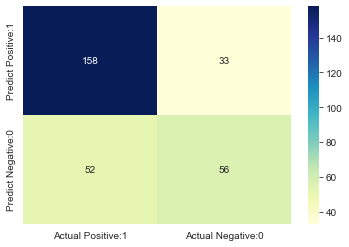

In [59]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

### Klasifikasi Matrix
#### Classification report
merupakan sebuah cara lain untuk mengevaluasi kinerja model klasifikasi. Ini menampilkan presisi, recall, f1 dan support scores untuk model.

In [61]:
# Membuat classification report

## TF-IDF ##
print('TF-IDF - linear C=1.0\n',
      classification_report(Test_Y, predictions_SVM_Tfidf_RBF100))

TF-IDF - linear C=1.0
               precision    recall  f1-score   support

           0       0.75      0.83      0.79       191
           1       0.63      0.52      0.57       108

    accuracy                           0.72       299
   macro avg       0.69      0.67      0.68       299
weighted avg       0.71      0.72      0.71       299



#### Classification accuracy

In [62]:
TP = cm[0,0]
TN = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [63]:
# print classification accuracy

classification_accuracy = (TP + TN) / float(TP + TN + FP + FN)

print('Classification accuracy : {0:0.4f}'.format(classification_accuracy))

Classification accuracy : 0.7157


In [64]:
# print classification error

classification_error = (FP + FN) / float(TP + TN + FP + FN)

print('Classification error : {0:0.4f}'.format(classification_error))

Classification error : 0.2843


### Validasi dengan K-Cross Validation
Ubah nilai n_splits sesuai dengan kebutuhan. Sebagai contoh, 5 splits berarti bahwa data (X dan y oversample) dibagi menjadi 4 porsi untuk set latih baru dan 1 porsi untuk set uji baru. Jika shuffle bernilai True, maka validasi silang dilakukan dengan kombinasi data yang berbeda di setiap iterasi. Kemudian validasi silang dilakukan dalam 5 iterasi.

#### Stratified k-Fold Cross Validation with shuffle split with rbf kernel

In [67]:
kfold=KFold(n_splits=5, shuffle=True, random_state=0)
rbf100_scores = cross_val_score(rbf100, Train_X_BoW, Train_Y, cv=kfold)

# print cross-validation scores with rbf kernel
print('/n/nStratified cross-validation scores with linear kernel:\n{}'.format(rbf100_scores))

/n/nStratified cross-validation scores with linear kernel:
[0.7        0.79285714 0.69784173 0.72661871 0.69064748]


In [68]:
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(rbf100_scores)*100, '%')
print('\nMinimum Accuracy:',
      min(rbf100_scores)*100, '%')
print('\nOverall Accuracy:',
      mean(rbf100_scores)*100, '%')
print('\nStandard Deviation is:', stdev(rbf100_scores))


Maximum Accuracy That can be obtained from this model is: 79.28571428571428 %

Minimum Accuracy: 69.06474820143885 %

Overall Accuracy: 72.15930113052416 %

Standard Deviation is: 0.04210653597691819


In [69]:
# Simpan nilai presisi, recall, dan f1-score ke file
def cr_oversampled(featExt, precision, recall, f1):
    output = 'svm_cr_inset_'+str(featExt)+'_kfold.txt'
    with open(output, 'a') as f:
        f.write(str(precision)+'\t'+str(recall)+'\t'+str(f1)+'\n')

In [70]:
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

y = LL
y = Encoder.fit_transform(y)

C:\Users\Chanchun\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [71]:
print('BoW - Karnel rbf(rbf=100.0)')
featExt = 'bow'

X = vectorizer.fit_transform(Corpus['text_final'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    linear1000.fit(X_train, y_train)
    y_pred = linear1000.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #print to file
    cr_oversampled(featExt, precision, recall, f1)

    print(f'# Fold {fold}:')
    print(classification_report(y_test, y_pred), "\n")
    
#     print(f'accuracy: {accuracy}')
#     print(f'precision: {precision}')
#     print(f'recall: {recall}')
#     print(f'f-score: {f1}')

BoW - Karnel rbf(rbf=100.0)
# Fold 1:
              precision    recall  f1-score   support

           0       0.80      0.81      0.81       127
           1       0.67      0.66      0.66        73

    accuracy                           0.76       200
   macro avg       0.74      0.73      0.73       200
weighted avg       0.75      0.76      0.75       200
 

# Fold 2:
              precision    recall  f1-score   support

           0       0.77      0.78      0.78       133
           1       0.55      0.53      0.54        66

    accuracy                           0.70       199
   macro avg       0.66      0.66      0.66       199
weighted avg       0.70      0.70      0.70       199
 

# Fold 3:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77       118
           1       0.68      0.51      0.58        81

    accuracy                           0.70       199
   macro avg       0.70      0.67      0.68       199
weighted avg

In [72]:
print('TF-IDF - Karnel RBF(C=100.0)')
featExt = 'tfidf'

X = Tfidf_vect.fit_transform(Corpus['text_final'])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    rbf100.fit(X_train, y_train)
    y_pred = rbf100.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    #print to file
    cr_oversampled(featExt, precision, recall, f1)

    print(f'# Fold {fold}:')
    print(classification_report(y_test, y_pred), "\n")

TF-IDF - Karnel RBF(C=100.0)
# Fold 1:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       127
           1       0.69      0.63      0.66        73

    accuracy                           0.76       200
   macro avg       0.74      0.73      0.74       200
weighted avg       0.76      0.76      0.76       200
 

# Fold 2:
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       133
           1       0.65      0.48      0.56        66

    accuracy                           0.74       199
   macro avg       0.71      0.68      0.69       199
weighted avg       0.73      0.74      0.73       199
 

# Fold 3:
              precision    recall  f1-score   support

           0       0.72      0.86      0.78       118
           1       0.71      0.52      0.60        81

    accuracy                           0.72       199
   macro avg       0.72      0.69      0.69       199
weighted av

In [73]:
# data00 = pd.read_csv('svm_cr_ov_lb1_tp_kfold.txt', header=None, sep='\t', names=['precision', 'recall', 'f1'])
data01 = pd.read_csv('svm_cr_inset_bow_kfold.txt', header=None, sep='\t', names=['precision', 'recall', 'f1'])
data02 = pd.read_csv('svm_cr_inset_tfidf_kfold.txt', header=None, sep='\t', names=['precision', 'recall', 'f1'])

### BoW
# Presisi rata-rata
data01_a = data01['precision'].to_list()
data01_a = sum(data01_a)/len(data01_a)*100
# Recall rata-rata
data01_b = data01['recall'].to_list()
data01_b = sum(data01_b)/len(data01_b)*100
# F1-score rata-rata
data01_c = data01['f1'].to_list()
data01_c = sum(data01_c)/len(data01_c)*100
# Menggabungkan semua nilai
data01 = [data01_a, data01_b, data01_c]
print(data01)

### TF-IDF
# Presisi rata-rata
data02_a = data02['precision'].to_list()
data02_a = sum(data02_a)/len(data02_a)*100
# Recall rata-rata
data02_b = data02['recall'].to_list()
data02_b = sum(data02_b)/len(data02_b)*100
# F1-score rata-rata
data02_c = data02['f1'].to_list()
data02_c = sum(data02_c)/len(data02_c)*100
# Menggabungkan semua nilai
data02 = [data02_a, data02_b, data02_c]
print(data02)

[65.60189909297051, 55.83380428129286, 60.12003257197682]
[72.61673534159534, 54.15970128298896, 61.766625258799166]


             presisi     recall  f-measure
0     BoW  65.601899  55.833804  60.120033
1  TF-IDF  72.616735  54.159701  61.766625


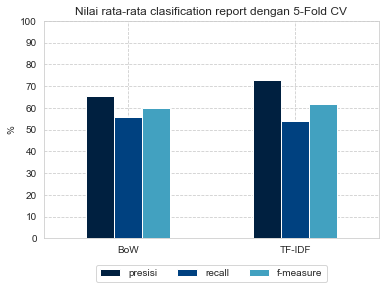

In [74]:
data = [['BoW', data01[0], data01[1], data01[2]],
        ['TF-IDF', data02[0], data02[1], data02[2]]]

dfx = pd.DataFrame(data, columns=['', 'presisi', 'recall', 'f-measure'])
print(dfx)

# plot multikolom dari dataframe
sns.set_palette('ocean',3)
ax = dfx.plot(x='', y=['presisi', 'recall', 'f-measure'], kind='bar')
ax.set_ylabel('%')
ax.set_title('Nilai rata-rata clasification report dengan 5-Fold CV')

ax.yaxis.set_ticks(np.arange(0, 110, 10))
lgd = ax.legend(loc='lower center', bbox_to_anchor=(0.5,-0.2), borderaxespad=0., ncol=3)
plt.xticks(rotation=0, ha='center')


## *Catatan: bbox_extra_artists harus berupa iterasi
# plt.savefig('plot5b-SVM_oversampled_kfold_avg_cr_inset.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()